# β-VAE Implementation for Disentangled Representations

A tutorial implementation for learning interpretable latent spaces

## Resources

- **GitHub Repository**: [Beta-VAE Implementation](https://github.com/Vishva2003/B-VAE_Implementation_for_Disentangled_Representations)
- **Webpage**: [β-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework](https://beta-vae-tutorial.vercel.app/)

---

## 📚 Table of Contents

1. [Introduction](#introduction)
2. [Theory Overview](#theory)
3. [Setup](#setup)
4. [Model Architecture](#architecture)
5. [Training](#training)
6. [Results & Visualization](#results)

---

## 🎯 Introduction

**What is β-VAE?**

Beta-VAE is an extension of Variational Autoencoders (VAEs) designed to learn **disentangled representations**. In a disentangled representation, each dimension of the latent space corresponds to a single, interpretable factor of variation in the data (e.g., hair color, pose, lighting).

**Key Concepts:**
- **Encoder**: Maps input images → latent space (compressed representation)
- **Decoder**: Maps latent space → reconstructed images
- **β (Beta)**: Controls the trade-off between reconstruction quality and disentanglement
  - β = 1: Standard VAE
  - β > 1: Encourages disentangled representations
  - Typical values: 4-10

**Why use β-VAE?**
- Learn interpretable features
- Control individual attributes of generated images
- Better generalization
- Useful for downstream tasks

---


## 📖 Theory Overview

### The VAE Loss Function

The β-VAE optimizes:

```
Loss = Reconstruction Loss + β × KL Divergence
```

**Reconstruction Loss**: Measures how well the model reconstructs the input
- Lower = better reconstruction
- Uses MSE (Mean Squared Error)

**KL Divergence**: Measures how much the learned latent distribution differs from a standard normal distribution
- Regularizes the latent space
- Ensures smooth interpolation
- β weights this term (higher β = more regularization)

### The Reparameterization Trick

To sample from the latent distribution while keeping it differentiable:
- Sample ε ~ N(0, 1)
- Compute z = μ + ε × σ

This allows gradients to flow through the sampling operation!

---


In [ ]:
# Finding Gpu Version
!nvidia-smi

Thu Dec 11 10:26:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Core PyTorch libraries
import torch                                    # Main PyTorch library
import torch.nn as nn                          # Neural network modules
import torch.nn.functional as F                # Functional operations (loss functions, etc.)
import torch.optim as optim                    # Optimization algorithms
from torch.utils.data import Dataset, DataLoader  # Data loading utilities

# Vision libraries
from torchvision import datasets, transforms   # Image datasets and transformations
from torch.utils.tensorboard import SummaryWriter  # Logging for TensorBoard

# Image and file handling
from PIL import Image                          # Python Imaging Library
import os                                      # Operating system interface

# Visualization and analysis
import matplotlib.pyplot as plt                # Plotting library
import numpy as np                            # Numerical operations
from tqdm.notebook import tqdm                # Progress bars
from torchvision.utils import make_grid       # Create image grids for visualization

# DEVICE CONFIGURATION
# Automatically detect if CUDA (GPU) is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


---

## Model Architecture

### 🏗️ Architecture Overview

The β-VAE consists of three main components:

1. **Encoder**: CNN that compresses 64×64 images → 128-dim latent vector
2. **Reparameterization**: Samples latent vector using the reparameterization trick
3. **Decoder**: Transposed CNN that reconstructs images from latent vectors

**Data Flow:**
```
Input Image (3×64×64)
    ↓
Encoder (Conv layers)
    ↓
Latent Parameters (μ, log σ²)
    ↓
Sample z = μ + ε×σ  (128-dim vector)
    ↓
Decoder (TransposedConv layers)
    ↓
Output Image (3×64×64)
```


In [ ]:

class Encoder(nn.Module):
    """
    Encoder network that maps images to latent space parameters.

    Args:
        in_channels (int): Number of input channels (3 for RGB, 1 for grayscale)
        latent_dim (int): Dimensionality of the latent space
        hidden_dims (list[int]): Number of channels at each convolutional layer

    Returns:
        mu (torch.Tensor): Mean of latent distribution, shape [batch_size, latent_dim]
        log_var (torch.Tensor): Log-variance of latent distribution, shape [batch_size, latent_dim]
    """
    def __init__(self, in_channels=3, latent_dim=128, hidden_dims=[32, 64, 128, 256]):
        super().__init__()
        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1] * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1] * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var


class Decoder(nn.Module):
    """
    Decoder network that reconstructs images from latent representations.

    Args:
        latent_dim (int): Dimensionality of the latent space
        hidden_dims (list[int]): Number of channels at each layer
        out_channels (int): Number of output channels (3 for RGB)

    Returns:
        torch.Tensor: Reconstructed images, shape [batch_size, out_channels, height, width]
    """

    def __init__(self, latent_dim=128, hidden_dims=[32, 64, 128, 256], out_channels=3):
        super().__init__()
        # Linear layer output should prepare for a 4x4 spatial resolution with
        # the deepest feature map depth from the encoder (hidden_dims[-1]).
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4 * 4)

        # Reverse hidden_dims for the upsampling layers to match encoder's downsampling
        decoder_hidden_dims = hidden_dims.copy() # Make a copy to avoid mutating the original list
        decoder_hidden_dims.reverse() # This will be [256, 128, 64, 32] based on config

        modules = []
        # The first ConvTranspose2d will take decoder_hidden_dims[0] (256) as input channels
        for i in range(len(decoder_hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(decoder_hidden_dims[i], decoder_hidden_dims[i + 1],
                                     kernel_size=3, stride=2, padding=1, output_padding=1),
                    nn.BatchNorm2d(decoder_hidden_dims[i + 1]),
                    nn.LeakyReLU()
                )
            )

        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(decoder_hidden_dims[-1], decoder_hidden_dims[-1],
                             kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(decoder_hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(decoder_hidden_dims[-1], out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        """
        Forward pass through the decoder.

        Args:
            z (torch.Tensor): Latent vectors, shape [batch_size, latent_dim]

        Returns:
            torch.Tensor: Reconstructed images, shape [batch_size, out_channels, height, width]
        """
        x = self.decoder_input(z) # Output is now (batch_size, 4096)
        # Reshape to the correct initial spatial dimensions (4x4) and channel depth (256)
        # The channel depth is derived from the linear layer's output features divided by spatial area (4*4)
        x = x.view(-1, self.decoder_input.out_features // (4*4), 4, 4)
        x = self.decoder(x)
        x = self.final_layer(x)
        return x


class BetaVAE(nn.Module):
    """
    Beta-VAE model for learning disentangled representations.

    Args:
        in_channels (int): Number of input channels
        latent_dim (int): Dimensionality of latent space
        hidden_dims (list[int]): Architecture specification
        beta (float): Weight of KL divergence term (controls disentanglement)

    Returns:
        tuple: (recon, mu, log_var)
            - recon (torch.Tensor): Reconstructed images, shape [batch_size, channels, H, W]
            - mu (torch.Tensor): Latent means, shape [batch_size, latent_dim]
            - log_var (torch.Tensor): Latent log-variances, shape [batch_size, latent_dim]
    """
    def __init__(self, in_channels=3, latent_dim=128, hidden_dims=[32, 64, 128, 256], beta=4.0):
        super().__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = Encoder(in_channels, latent_dim, hidden_dims)
        self.decoder = Decoder(latent_dim, hidden_dims.copy(), in_channels) # Pass a copy of hidden_dims

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        recon = self.decoder(z)
        return recon, mu, log_var

    def sample(self, num_samples, device):
        z = torch.randn(num_samples, self.latent_dim).to(device)
        samples = self.decoder(z)
        return samples

    def encode(self, x):
        mu, _ = self.encoder(x)
        return mu

print("Model architecture defined!")

# =====================================


Model architecture defined!


## Dataset Utilities

### 📂 Data Loading Pipeline

This section handles loading and preprocessing your images:

1. **CustomImageDataset**: Loads images from a folder
2. **get_dataloaders**: Creates train/validation splits and batches

In [ ]:

class CustomImageDataset(Dataset):
    """
    Custom PyTorch Dataset for loading images from a directory.

    Args:
        root_dir (str): Path to directory containing images
        transform (callable, optional): Transformations to apply
        img_size (int): Target size to resize images to

    Returns:
        torch.Tensor: Transformed image tensor, shape [channels, img_size, img_size]
    """
    def __init__(self, root_dir, transform=None, img_size=64):
        self.root_dir = root_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])
        self.images = [os.path.join(root_dir, f) for f in os.listdir(root_dir)
                      if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        print(f"Found {len(self.images)} images in {root_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB')
        return self.transform(img)


def get_dataloaders(data_path, batch_size=64, img_size=64, num_workers=2):
    """
    Create training and validation DataLoaders.

    Args:
        data_path (str): Path to the dataset directory
        batch_size (int): Number of images per batch
        img_size (int): Size to resize images to
        num_workers (int): Number of parallel workers

    Returns:
        tuple: (train_loader, val_loader)
            - train_loader (DataLoader): Training data loader
            - val_loader (DataLoader): Validation data loader
    """
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])

    #Custom image folder

    dataset = CustomImageDataset(data_path, transform, img_size)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                             num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader

print("Dataset utilities defined!")

Dataset utilities defined!


## Loss Function

### 📉 Understanding the β-VAE Loss

The loss function has two components:

1. **Reconstruction Loss**: How well can we recreate the input?
   - Uses Mean Squared Error (MSE)
   - Measures pixel-wise difference

2. **KL Divergence**: How close is our latent distribution to N(0, 1)?
   - Regularizes the latent space
   - Multiplied by β for disentanglement control

**Formula:**
```
Total Loss = Reconstruction Loss + β × KL Divergence
```


In [ ]:

def bvae_loss(recon_x, x, mu, log_var, beta=4.0):
    """
    Beta-VAE loss function combining reconstruction and KL divergence.

    Loss = Reconstruction Loss + β × KL Divergence

    Args:
        recon_x (torch.Tensor): Reconstructed images, shape [batch_size, C, H, W]
        x (torch.Tensor): Original images, shape [batch_size, C, H, W]
        mu (torch.Tensor): Latent means, shape [batch_size, latent_dim]
        log_var (torch.Tensor): Latent log-variances, shape [batch_size, latent_dim]
        beta (float): Weight for KL divergence term

    Returns:
        tuple: (total_loss, recon_loss, kl_loss)
            - total_loss (torch.Tensor): Combined loss (scalar)
            - recon_loss (torch.Tensor): Reconstruction loss (scalar)
            - kl_loss (torch.Tensor): KL divergence loss (scalar)
    """
    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Total loss with beta weighting
    loss = recon_loss + beta * kl_loss

    return loss, recon_loss, kl_loss

print("Loss function defined!")

Loss function defined!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configuration

### ⚙️ Hyperparameters

This section defines all training parameters. Adjust these based on your needs!

In [ ]:

DATA_TAR  = Path("/content/drive/MyDrive/CelebA.zip")
DATA_ROOT = Path("./CelebA")

# Error message if celebA.zip not found
assert DATA_TAR.exists(), "Please upload celebA.zip to Google Drive (MyDrive)."

# Extract ZIP if folder does not exist
if not DATA_ROOT.exists():
    with ZipFile(DATA_TAR, 'r') as zip_ref:
        zip_ref.extractall("./")



In [ ]:
config = {
    'data_path':'./img_align_celeba',
    'batch_size': 32,                    # Images per batch (reduce if out of memory)
    'img_size': 64,                      # Image resolution (64x64)

    # Model architecture
    'latent_dim': 128,                   # Size of latent space (higher = more expressive)
    'hidden_dims': [32, 64, 128, 256],   # Channels at each conv layer

    # Training hyperparameters
    'beta': 4.0,                         # Disentanglement weight (1-10)
    'lr': 1e-4,                          # Learning rate
    'epochs': 50,                        # Number of training epochs

    # Paths
    'save_dir': './checkpoints',         # Where to save model checkpoints
    'log_dir': './runs'                  # TensorBoard logs directory
}

# Create directories
os.makedirs(config['save_dir'], exist_ok=True)
os.makedirs(config['log_dir'], exist_ok=True)

print("Configuration:")
for k, v in config.items():
    print(f"  {k}: {v}")

Configuration:
  data_path: ./img_align_celeba
  batch_size: 32
  img_size: 64
  latent_dim: 128
  hidden_dims: [32, 64, 128, 256]
  beta: 4.0
  lr: 0.0001
  epochs: 10
  save_dir: ./checkpoints
  log_dir: ./runs


## Load Data

### 📊 Dataset Preparation

Found 202599 images in ./img_align_celeba

Dataset loaded!
Training batches: 5065
Validation batches: 1267


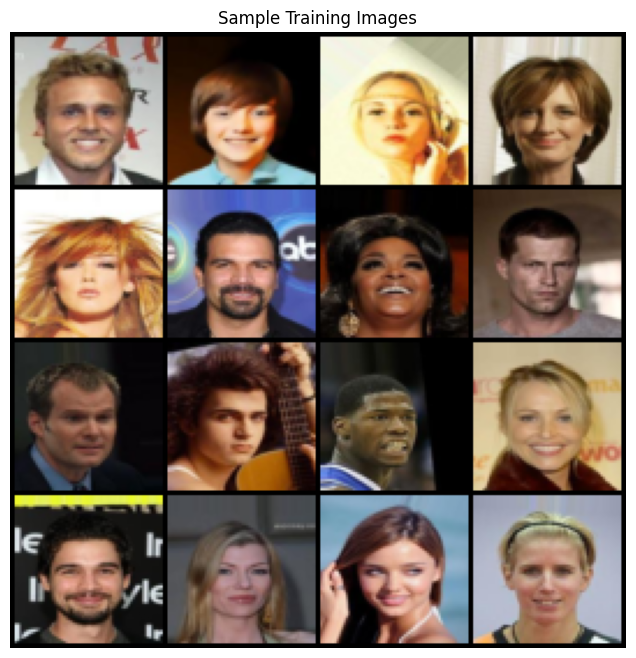

In [ ]:

train_loader, val_loader = get_dataloaders(
    config['data_path'],
    config['batch_size'],
    config['img_size'],
    num_workers=0
)

print(f"\nDataset loaded!")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Visualize a batch
sample_batch = next(iter(train_loader))
grid = make_grid(sample_batch[:16], nrow=4, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Sample Training Images')
plt.show()

## Initialize Model

### 🚀 Model Setup

In [ ]:
# Create the β-VAE model
model = BetaVAE(
    in_channels=3,
    latent_dim=config['latent_dim'],
    hidden_dims=config['hidden_dims'],
    beta=config['beta']
).to(device)

# Setup optimizer (Adam is standard for VAEs)
optimizer = optim.Adam(model.parameters(), lr=config['lr'])

# Learning rate scheduler (reduces LR when validation loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Count total parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model initialized with {total_params:,} trainable parameters")

Model initialized with 2,364,515 trainable parameters


## Training Functions

### 🎓 Training & Validation Logic

In [ ]:

def train_epoch(model, train_loader, optimizer, beta):
    """
    Train the model for one epoch.

    Args:
        model (BetaVAE): The model to train
        train_loader (DataLoader): Training data loader
        optimizer (torch.optim.Optimizer): Optimizer
        beta (float): Beta parameter for loss

    Returns:
        tuple: (avg_loss, avg_recon, avg_kl)
            - avg_loss (float): Average total loss
            - avg_recon (float): Average reconstruction loss
            - avg_kl (float): Average KL divergence loss
    """
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    pbar = tqdm(train_loader, desc='Training')
    for batch in pbar:
        batch = batch.to(device)

        optimizer.zero_grad()
        recon, mu, log_var = model(batch)
        loss, recon_loss, kl_loss = bvae_loss(recon, batch, mu, log_var, beta)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

        pbar.set_postfix({
            'loss': f'{loss.item() / len(batch):.4f}',
            'recon': f'{recon_loss.item() / len(batch):.4f}',
            'kl': f'{kl_loss.item() / len(batch):.4f}'
        })

    n = len(train_loader.dataset)
    return total_loss / n, total_recon / n, total_kl / n


def validate(model, val_loader, beta):
    """
    Validate the model on the validation set.

    Args:
        model (BetaVAE): The model to evaluate
        val_loader (DataLoader): Validation data loader
        beta (float): Beta parameter for loss
    Returns:
        tuple: (avg_loss, avg_recon, avg_kl)
            - avg_loss (float): Average total loss
            - avg_recon (float): Average reconstruction loss
            - avg_kl (float): Average KL divergence loss
    """
    model.eval()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            recon, mu, log_var = model(batch)
            loss, recon_loss, kl_loss = bvae_loss(recon, batch, mu, log_var, beta)

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()

    n = len(val_loader.dataset)
    return total_loss / n, total_recon / n, total_kl / n

print("Training functions defined!")

Training functions defined!


## Training Loop

### 🏋️ Main Training Process

This is where the magic happens! The model learns to encode and decode images.

**What to expect:**
- Training takes time (5-30 minutes per epoch depending on GPU/CPU)
- Loss should decrease over epochs
- Best model is automatically saved
- You can stop training anytime (Ctrl+C) and resume later

In [ ]:

# Initialize tracking
train_losses = []
val_losses = []
best_val_loss = float('inf')

writer = SummaryWriter(config['log_dir'])

for epoch in range(config['epochs']):
    print(f'\nEpoch {epoch + 1}/{config["epochs"]}')
    print('-' * 50)

    # Train
    train_loss, train_recon, train_kl = train_epoch(model, train_loader, optimizer, config['beta'])

    # Validate
    val_loss, val_recon, val_kl = validate(model, val_loader, config['beta'])

    # Logging
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Recon/train', train_recon, epoch)
    writer.add_scalar('KL/train', train_kl, epoch)

    print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
    print(f'Train Recon: {train_recon:.4f} | Train KL: {train_kl:.4f}')

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, os.path.join(config['save_dir'], 'best_model.pt'))
        print(f'✓ Saved best model (val_loss: {val_loss:.4f})')

    # Periodic checkpoint
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, os.path.join(config['save_dir'], f'checkpoint_epoch_{epoch+1}.pt'))

writer.close()
print("\nTraining completed!")


Epoch 1/10
--------------------------------------------------


Training:   0%|          | 0/5065 [00:00<?, ?it/s]

Train Loss: 394.5078 | Val Loss: 334.9574
Train Recon: 300.3189 | Train KL: 23.5472
✓ Saved best model (val_loss: 334.9574)

Epoch 2/10
--------------------------------------------------


Training:   0%|          | 0/5065 [00:00<?, ?it/s]

Train Loss: 333.6481 | Val Loss: 323.5454
Train Recon: 234.2711 | Train KL: 24.8443
✓ Saved best model (val_loss: 323.5454)

Epoch 3/10
--------------------------------------------------


Training:   0%|          | 0/5065 [00:00<?, ?it/s]

Train Loss: 325.3490 | Val Loss: 318.6878
Train Recon: 225.6538 | Train KL: 24.9238
✓ Saved best model (val_loss: 318.6878)

Epoch 4/10
--------------------------------------------------


Training:   0%|          | 0/5065 [00:00<?, ?it/s]

Train Loss: 320.7966 | Val Loss: 317.0323
Train Recon: 221.0268 | Train KL: 24.9424
✓ Saved best model (val_loss: 317.0323)

Epoch 5/10
--------------------------------------------------


Training:   0%|          | 0/5065 [00:00<?, ?it/s]

Train Loss: 318.1360 | Val Loss: 314.0205
Train Recon: 218.4339 | Train KL: 24.9255
✓ Saved best model (val_loss: 314.0205)

Epoch 6/10
--------------------------------------------------


Training:   0%|          | 0/5065 [00:00<?, ?it/s]

Train Loss: 315.9625 | Val Loss: 311.5667
Train Recon: 216.2462 | Train KL: 24.9291
✓ Saved best model (val_loss: 311.5667)

Epoch 7/10
--------------------------------------------------


Training:   0%|          | 0/5065 [00:00<?, ?it/s]

Train Loss: 314.4395 | Val Loss: 312.2209
Train Recon: 214.5508 | Train KL: 24.9722

Epoch 8/10
--------------------------------------------------


Training:   0%|          | 0/5065 [00:00<?, ?it/s]

Train Loss: 313.0726 | Val Loss: 309.2976
Train Recon: 213.1202 | Train KL: 24.9881
✓ Saved best model (val_loss: 309.2976)

Epoch 9/10
--------------------------------------------------


Training:   0%|          | 0/5065 [00:00<?, ?it/s]

Train Loss: 311.9007 | Val Loss: 308.5270
Train Recon: 211.8742 | Train KL: 25.0066
✓ Saved best model (val_loss: 308.5270)

Epoch 10/10
--------------------------------------------------


Training:   0%|          | 0/5065 [00:00<?, ?it/s]

Train Loss: 311.1093 | Val Loss: 307.7367
Train Recon: 210.9997 | Train KL: 25.0274
✓ Saved best model (val_loss: 307.7367)

Training completed!


### 📈 Loss Plot Analysis

These plots visualize the training progress of our Beta-VAE model:

**1. Training and Validation Loss (Left Plot):**
- This plot shows both the **Training Loss** (blue line) and **Validation Loss** (orange line) over the course of training epochs.
- Both losses decrease steadily, indicating that the model is learning effectively and generalizing well to unseen data (validation set).
- The validation loss closely follows the training loss, suggesting that the model is not significantly overfitting.

**2. Training Loss (Log Scale) (Right Plot):**
- This plot displays the **Training Loss** on a logarithmic scale.
- A log scale can be useful for visualizing initial rapid drops in loss and then finer changes as training progresses.
- It confirms the consistent reduction in loss, demonstrating stable learning.

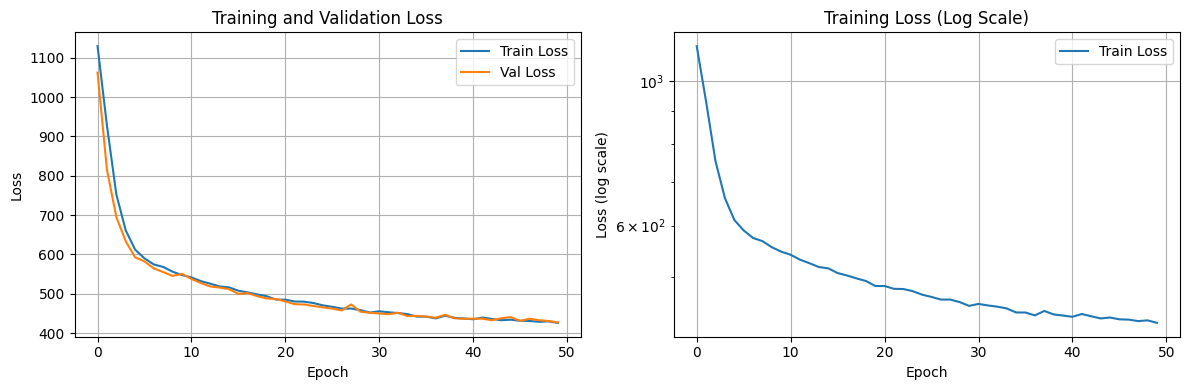

In [ ]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.title('Training Loss (Log Scale)')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Load best model
checkpoint = torch.load(os.path.join(config['save_dir'], 'best_model.pt'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Loaded best model from epoch {checkpoint['epoch']} with val_loss: {checkpoint['val_loss']:.4f}")


Loaded best model from epoch 9 with val_loss: 307.7367


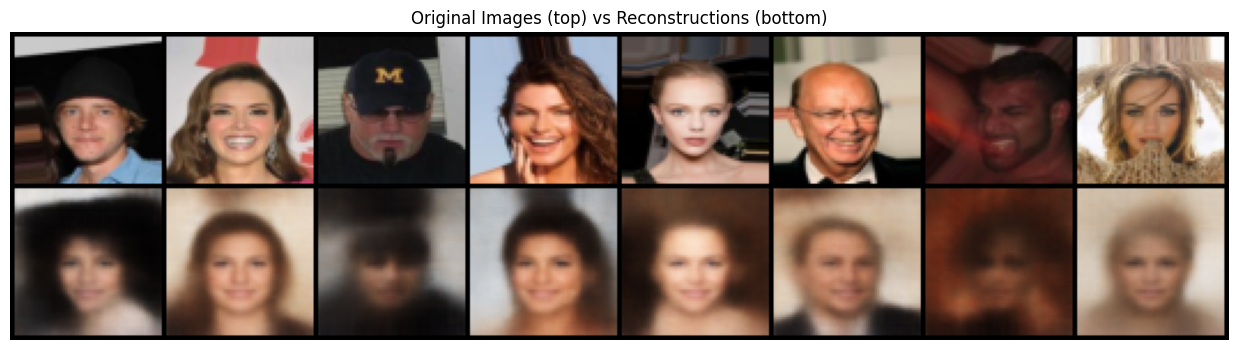

In [ ]:

# Get a batch of test images
test_batch = next(iter(val_loader))
test_images = test_batch[:8].to(device)

with torch.no_grad():
    recons, _, _ = model(test_images)

# Create comparison
comparison = torch.cat([test_images, recons])
grid = make_grid(comparison.cpu(), nrow=8, normalize=True)

plt.figure(figsize=(16, 4))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Original Images (top) vs Reconstructions (bottom)')
plt.show()

### 🖼️ Original vs. Reconstructed Images

This visualization shows a direct comparison between original input images and their reconstructions generated by the β-VAE model.

- **Top Row**: Displays a selection of original images from the validation set.
- **Bottom Row**: Shows the corresponding images reconstructed by the VAE after passing them through the encoder (to get the latent representation) and then the decoder.

**Analysis:**
- **Reconstruction Quality**: The closeness of the reconstructed images to the originals indicates how well the model has learned to capture the features of the input data. Good reconstructions imply a strong decoder and an effective latent representation.
- **Blurriness**: VAEs often produce slightly blurry reconstructions. This is a common characteristic, as the model learns a probabilistic distribution and averages over possible outputs, rather than memorizing exact pixel values. It also relates to the trade-off with the KL divergence term, which encourages a simpler latent space.

This plot confirms the model's ability to compress and decompress image information, forming the basis for its generative capabilities.

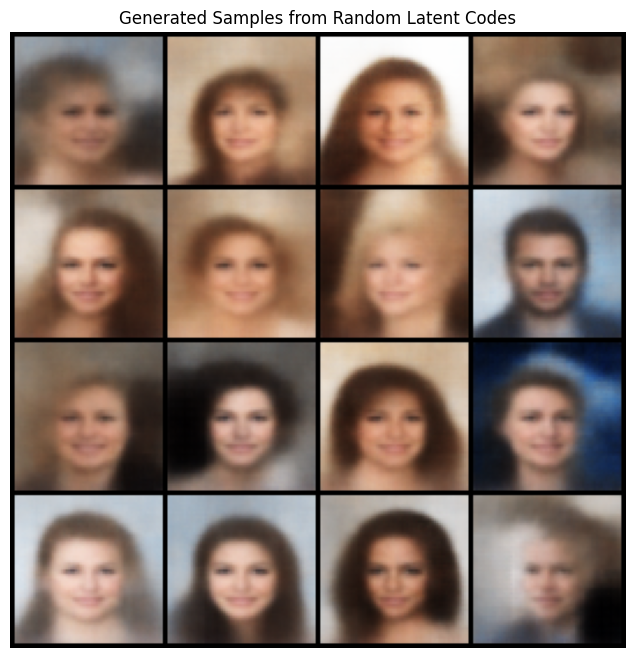

In [ ]:

num_samples = 16
with torch.no_grad():
    samples = model.sample(num_samples, device)

grid = make_grid(samples.cpu(), nrow=4, normalize=True)

plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Generated Samples from Random Latent Codes')
plt.show()


### ✨ Generated Samples from Random Latent Codes

This plot showcases images generated by feeding randomly sampled latent vectors into the decoder of the β-VAE. Each image in this grid is a completely new creation by the model, demonstrating its generative capabilities.

**Analysis:**
- **Diversity**: The variety among the generated faces suggests that the latent space is rich and captures different attributes of the CelebA dataset (e.g., hairstyles, facial features, expressions).
- **Fidelity**: While some generated images might be slightly blurry (a common characteristic of VAEs), they generally resemble plausible human faces, indicating that the model has learned meaningful features.
- **Smoothness**: The ability to generate diverse yet coherent images from random points implies a continuous and well-structured latent space, a key goal of VAEs. If the latent space were disjointed, random sampling would likely produce nonsensical images.

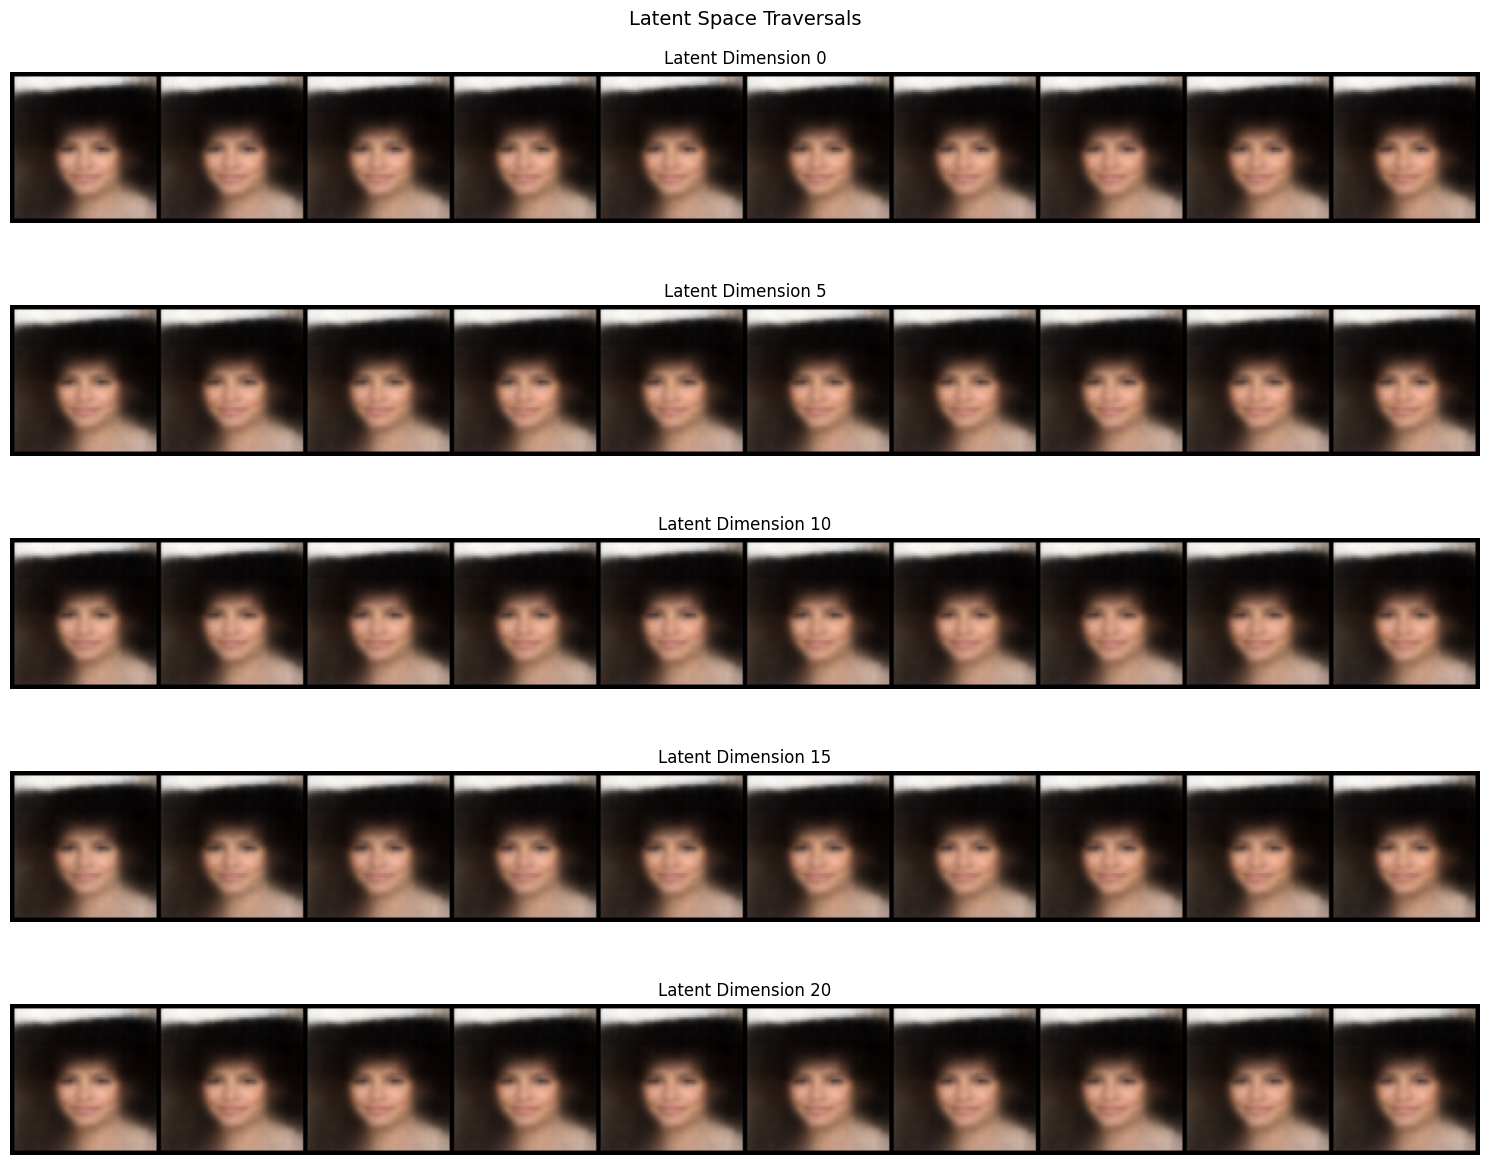

In [ ]:

def latent_traversal(model, image, dim_idx, n_steps=10, range_val=3):
    """Traverse a single latent dimension
    Args:
        model (BetaVAE): The model to use
        image (torch.Tensor): Input image
        dim_idx (int): Index of the latent dimension to traverse
        n_steps (int): Number of steps to traverse the dimension
        range_val (float): Range of values to traverse the dimension
    Returns:
        torch.Tensor: Traversed images
    """
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        mu, _ = model.encoder(image)

        traversals = []
        values = torch.linspace(-range_val, range_val, n_steps)

        for val in values:
            z = mu.clone()
            z[0, dim_idx] = val
            recon = model.decoder(z)
            traversals.append(recon)

        return torch.cat(traversals, dim=0)

# Select an image and traverse multiple dimensions
test_image = test_batch[0]

fig, axes = plt.subplots(5, 1, figsize=(15, 12))

for i, dim in enumerate([0, 5, 10, 15, 20]):
    traversal = latent_traversal(model, test_image, dim, n_steps=10)
    grid = make_grid(traversal.cpu(), nrow=10, normalize=True)

    axes[i].imshow(grid.permute(1, 2, 0))
    axes[i].axis('off')
    axes[i].set_title(f'Latent Dimension {dim}')

plt.tight_layout()
plt.suptitle('Latent Space Traversals', y=1.002, fontsize=14)
plt.show()

### Latent Space Traversals

This visualization demonstrates how individual dimensions within the β-VAE's latent space influence the generated images. By systematically varying a single latent dimension while keeping others constant, we can observe the specific visual attributes controlled by that dimension.

**Process:**
1. An input image is first encoded to obtain its mean latent vector (μ).
2. For a chosen latent dimension (e.g., dimension 0, 5, 10), its value is varied across a predefined range (e.g., from -3 to +3) in discrete steps.
3. All other latent dimensions are kept fixed to their original values from the encoded image.
4. Each modified latent vector is then passed through the decoder to generate a new image.

**Analysis:**
- **Disentanglement**: If the β-VAE has successfully learned disentangled representations, changing a single latent dimension should ideally correspond to a change in only one interpretable feature of the generated image (e.g., hair color, pose, illumination, facial expression) without affecting others.
- **Interpretability**: This technique helps to interpret what each latent dimension represents. For example, one dimension might control the presence of glasses, another the age, and yet another the gender.
- **Smoothness**: The smooth transitions observed as a latent dimension is traversed indicate a continuous and well-structured latent space, allowing for gradual manipulation of image attributes.

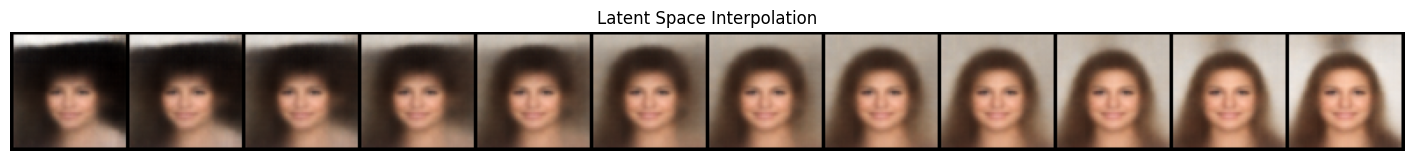

In [ ]:
def interpolate_latent(model, img1, img2, n_steps=10):
    """Interpolate between two images in latent space
    Args:
        model (BetaVAE): The model to use
        img1 (torch.Tensor): First image
        img2 (torch.Tensor): Second image
        n_steps (int): Number of steps to interpolate between images
    Returns:
        torch.Tensor: Interpolated images
    """
    model.eval()
    with torch.no_grad():
        img1 = img1.unsqueeze(0).to(device)
        img2 = img2.unsqueeze(0).to(device)

        mu1, _ = model.encoder(img1)
        mu2, _ = model.encoder(img2)

        interpolations = []
        alphas = torch.linspace(0, 1, n_steps)

        for alpha in alphas:
            z = (1 - alpha) * mu1 + alpha * mu2
            recon = model.decoder(z)
            interpolations.append(recon)

        return torch.cat(interpolations, dim=0)

# Interpolate between two images
img1 = test_batch[0]
img2 = test_batch[1]

interpolated = interpolate_latent(model, img1, img2, n_steps=12)
grid = make_grid(interpolated.cpu(), nrow=12, normalize=True)

plt.figure(figsize=(18, 3))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Latent Space Interpolation')
plt.show()


### ↔️ Latent Space Interpolation

This visualization demonstrates the smoothness and continuity of the learned latent space by interpolating between the latent representations of two different input images.

**Process:**
1. Two distinct images are encoded into their respective latent mean vectors (μ1 and μ2).
2. A series of intermediate latent vectors are created by linearly interpolating between μ1 and μ2.
3. Each intermediate latent vector is then fed into the decoder to generate a corresponding image.

**Analysis:**
- **Smooth Transitions**: The smooth, gradual morphing from one face to another indicates that the latent space is continuous. There are no abrupt jumps or illogical changes, which is a hallmark of a well-formed latent representation.
- **Feature Blending**: As the interpolation progresses, features from the first image subtly transform into features of the second image (e.g., hair color, face shape, accessories). This demonstrates that the model has learned disentangled or semi-disentangled features, allowing for smooth transitions between different attributes.
- **Understanding Latent Dimensions**: This capability is crucial for understanding how different features are represented in the latent space and for manipulating image attributes in a controlled manner.

In [ ]:

# Save final model with full configuration
final_save_path = os.path.join(config['save_dir'], 'final_model.pt')
torch.save({
    'config': config,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
}, final_save_path)

print(f"Final model saved to: {final_save_path}")
print("\nTo load this model later, use:")
print("checkpoint = torch.load('path/to/final_model.pt')")
print("model.load_state_dict(checkpoint['model_state_dict'])")

Final model saved to: ./checkpoints/final_model.pt

To load this model later, use:
checkpoint = torch.load('path/to/final_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
